pybullet build time: Nov 28 2023 23:45:17


startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Intel
GL_RENDERER=Mesa Intel(R) UHD Graphics 620 (KBL GT2)
GL_VERSION=4.6 (Core Profile) Mesa 23.2.1-1ubuntu3.1~22.04.2
GL_SHADING_LANGUAGE_VERSION=4.60
pthread_getconcurrency()=0
Version = 4.6 (Core Profile) Mesa 23.2.1-1ubuntu3.1~22.04.2
Vendor = Intel
Renderer = Mesa Intel(R) UHD Graphics 620 (KBL GT2)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubuntu
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubu

100%|██████████| 12000/12000 [00:20<00:00, 574.47it/s]


numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed


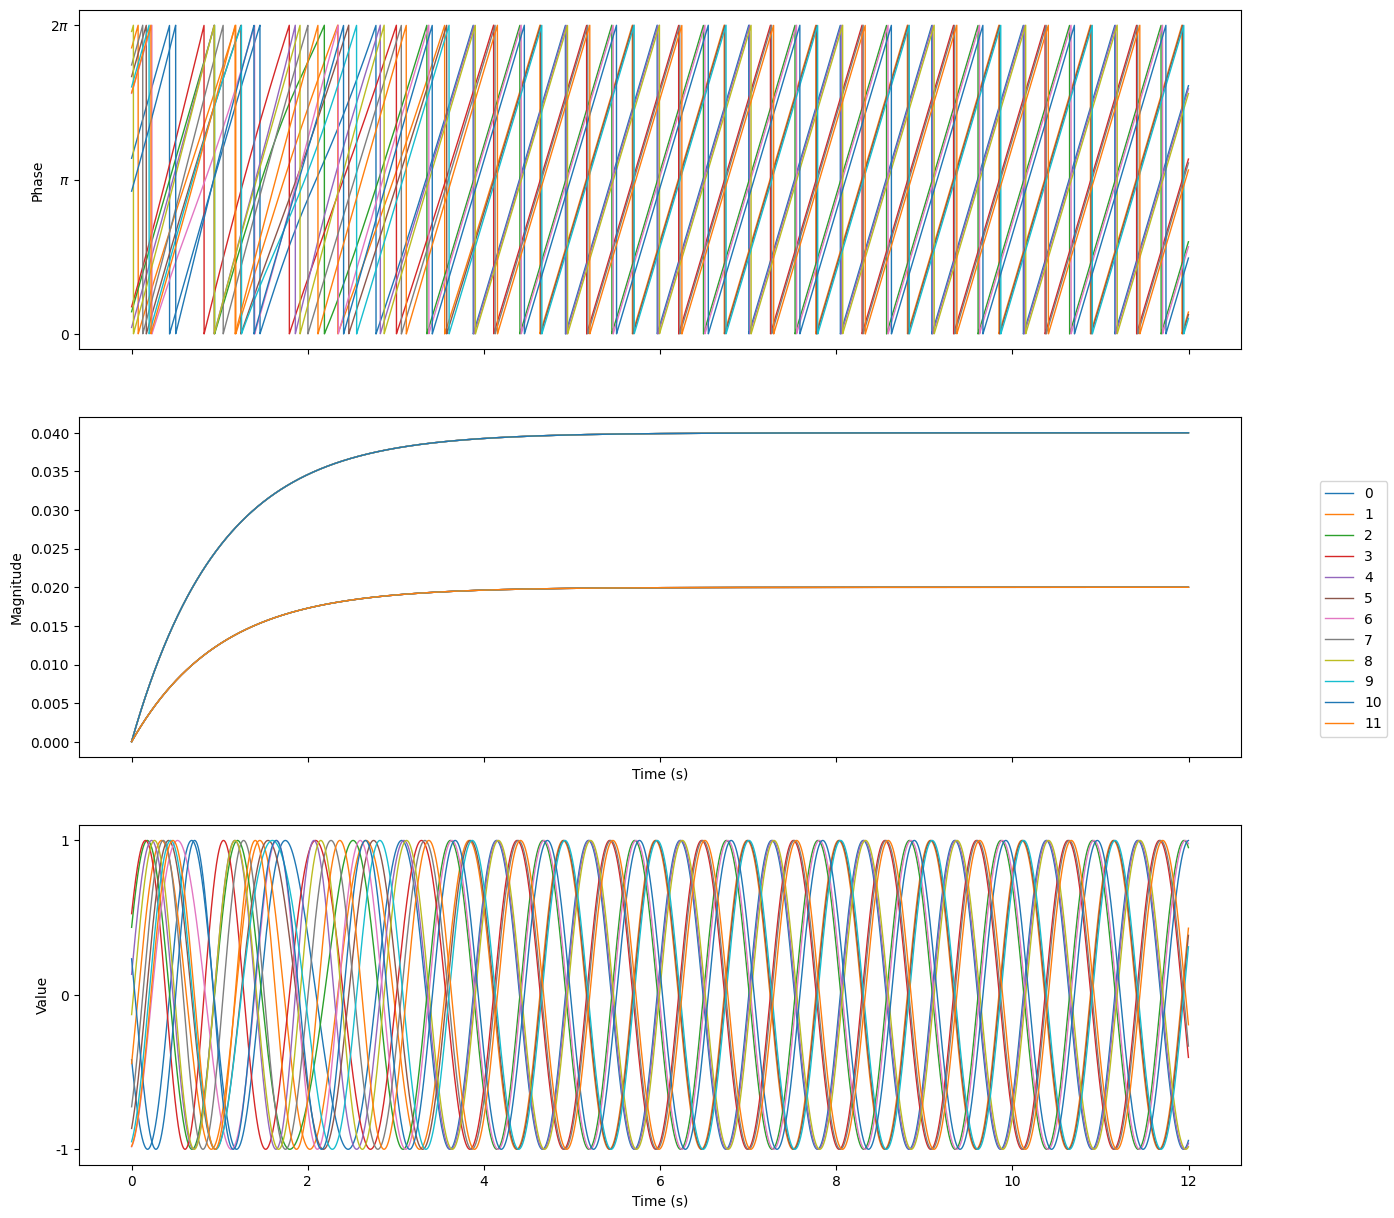

In [1]:
import time
import pybullet as p
import pybullet_data
import math
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import trange

frequence = 1000
timestep = 1./frequence
num_steps = 12 * frequence

x1 = 0.27
y1 = 0.16
y2 = 0.32
z1 = -0.1
base_position = [x1,y1,z1]

# Connect to PyBullet and set up the environment
p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0, 0, -9.81)
p.setRealTimeSimulation(0)  # Use step simulation for better control
p.setTimeStep(timestep)  # Set a higher time step for smoother simulation
p.setPhysicsEngineParameter(numSolverIterations=50) 

camera_target_position = [0, 0, 0] # Position to look at
camera_distance = 1 # Distance from the target
camera_yaw = 165 # Yaw angle
camera_pitch = -40 # Pitch angle

# Calculate the camera position
camera_position = [
camera_target_position[0] + camera_distance * math.sin(math.radians(camera_yaw)) * math.cos(math.radians(camera_pitch)),
camera_target_position[1] + camera_distance * math.sin(math.radians(camera_pitch)),
camera_target_position[2] + camera_distance * math.cos(math.radians(camera_yaw)) * math.cos(math.radians(camera_pitch))
]
# Set the camera
p.resetDebugVisualizerCamera(cameraDistance=camera_distance,
cameraYaw=camera_yaw,
cameraPitch=camera_pitch,
cameraTargetPosition=camera_target_position)


# Load the plane and the mill URDF model
plane_id = p.loadURDF("plane.urdf")
robot_id = p.loadURDF("hexapod_2.urdf", useFixedBase=0, basePosition=[0, 0, 0.2], baseOrientation=[0, 0, 0, 1],)
# sphere_id = []
# for i in range(6):
#     sphere_id.append(p.loadURDF("sphere.urdf", useFixedBase=1, basePosition=[0,0,0.1], globalScaling=0.5))

# Joints info
jointIndex = {}
revoluteJointIndex = {}
endEffectorIndex = {}
numJoints = p.getNumJoints(robot_id)
for i in range(numJoints):
    jointInfo = p.getJointInfo(robot_id, i)
    key = jointInfo[1].decode('utf-8')
    jointIndex[key] = i
    if key[0] == 'u' or key[0] == 'v' or key[0] == 'w':
        revoluteJointIndex[key] = i
    elif key[0] == 'x':
        endEffectorIndex[key] = i
N = len(revoluteJointIndex)

# Change dynamics
#p.changeDynamics(plane_id, -1, lateralFriction=1.0)

for idx in revoluteJointIndex.values():
    p.changeDynamics(
        bodyUniqueId=robot_id,
        linkIndex=idx,
        jointDamping=0.1             # Damping specifically for joints
    )

for idx in endEffectorIndex.values():
    p.changeDynamics(
        bodyUniqueId=robot_id,
        linkIndex=idx,
        lateralFriction=1,         # Lateral friction coefficient
        contactStiffness=10.0,     # Stiffness of contact constraints
        contactDamping=0.5,          # Damping of contact constraints
    )

# Variables
end_effector_world_position = [0,0,0,0,0,0]

# Debug parameters
range_max = 0.5
x1 = 0.16
y2 = 0.24
y1 = 0.16
z1 = -0.07
x1_id = p.addUserDebugParameter("X1", 0 , range_max, x1)
y1_id = p.addUserDebugParameter("Y1", 0 , range_max, y1)
y2_id = p.addUserDebugParameter("Y2", 0 , range_max, y2)
z1_id = p.addUserDebugParameter("Z1", -range_max , 0, z1)

#-------------------------------------------------------------------------------------
# CPG ///////////////////////////////////////////////////////////////////////////////
#-------------------------------------------------------------------------------------

def calculate_ddt(theta, r, w, phi, nu, R, alpha):
    """Given the current state variables theta, r and network parameters
    w, phi, nu, R, alpha, calculate the time derivatives of theta and r."""
    intrinsic_term = 2 * np.pi * nu
    phase_diff = theta[np.newaxis, :] - theta[:, np.newaxis]
    coupling_term = (r * w * np.sin(phase_diff - phi)).sum(axis=1)
    dtheta_dt = intrinsic_term + coupling_term
    dr_dt = alpha * (R - r)
    return dtheta_dt, dr_dt

class CPGNetwork:
    def __init__(
        self,
        timestep,
        intrinsic_freqs,
        intrinsic_amps,
        coupling_weights,
        phase_biases,
        convergence_coefs,
        init_phases=None,
        init_magnitudes=None,
        seed=0,
    ) -> None:
        """Initialize a CPG network consisting of N oscillators.

        Parameters
        ----------
        timestep : float
            The timestep of the simulation.
        intrinsic_freqs : np.ndarray
            The intrinsic frequencies of the oscillators, shape (N,).
        intrinsic_amps : np.ndarray
            The intrinsic amplitude of the oscillators, shape (N,).
        coupling_weights : np.ndarray
            The coupling weights between the oscillators, shape (N, N).
        phase_biases : np.ndarray
            The phase biases between the oscillators, shape (N, N).
        convergence_coefs : np.ndarray
            Coefficients describing the rate of convergence to oscillator
            intrinsic amplitudes, shape (N,).
        init_phases : np.ndarray, optional
            Initial phases of the oscillators, shape (N,). The phases are
            randomly initialized if not provided.
        init_magnitudes : np.ndarray, optional
            Initial magnitudes of the oscillators, shape (N,). The
            magnitudes are randomly initialized if not provided.
        seed : int, optional
            The random seed to use for initializing the phases and
            magnitudes.
        """
        self.timestep = timestep
        self.num_cpgs = intrinsic_freqs.size
        self.intrinsic_freqs = intrinsic_freqs
        self.intrinsic_amps = intrinsic_amps
        self.coupling_weights = coupling_weights
        self.phase_biases = phase_biases
        self.convergence_coefs = convergence_coefs
        self.random_state = np.random.RandomState(seed)

        self.reset(init_phases, init_magnitudes)

        # Check if the parameters have the right shape
        assert intrinsic_freqs.shape == (self.num_cpgs,)
        assert coupling_weights.shape == (self.num_cpgs, self.num_cpgs)
        assert phase_biases.shape == (self.num_cpgs, self.num_cpgs)
        assert convergence_coefs.shape == (self.num_cpgs,)
        assert self.curr_phases.shape == (self.num_cpgs,)
        assert self.curr_magnitudes.shape == (self.num_cpgs,)

    def step(self):
        """Integrate the ODEs using Euler's method."""
        dtheta_dt, dr_dt = calculate_ddt(
            theta=self.curr_phases,
            r=self.curr_magnitudes,
            w=self.coupling_weights,
            phi=self.phase_biases,
            nu=self.intrinsic_freqs,
            R=self.intrinsic_amps,
            alpha=self.convergence_coefs,
        )
        self.curr_phases += dtheta_dt * self.timestep
        self.curr_phases %= 2*np.pi
        self.curr_magnitudes += dr_dt * self.timestep

        return self.curr_phases, self.curr_magnitudes

    def reset(self, init_phases=None, init_magnitudes=None):
        """Reset the phases and magnitudes of the oscillators.
        High magnitudes and unfortunate phases might cause physics error
        """
        if init_phases is None:
            self.curr_phases = self.random_state.random(self.num_cpgs) * 2 * np.pi
        else:
            self.curr_phases = init_phases

        if init_magnitudes is None:
            self.curr_magnitudes = np.zeros(self.num_cpgs)
        else:
            self.curr_magnitudes = init_magnitudes

num_cpg = 12
intrinsic_freqs = np.ones(num_cpg)
amp_x = 0.04
amp_z = 0.02
intrinsic_amps = np.array([amp_x,amp_z,amp_x,amp_z,amp_x,amp_z,amp_x,amp_z,amp_x,amp_z,amp_x,amp_z])
coupling_weights = np.array(
    [
        [0,1,1,0,1,0,0,0,0,0,0,0],
        [1,0,0,1,0,1,0,0,0,0,0,0],
        [1,0,0,1,1,0,1,0,0,0,0,0],
        [0,1,1,0,0,1,0,1,0,0,0,0],
        [1,0,1,0,0,1,1,0,1,0,0,0],
        [0,1,0,1,1,0,0,1,0,1,0,0],
        [0,0,1,0,1,0,0,1,1,0,1,0],
        [0,0,0,1,0,1,1,0,0,1,0,1],
        [0,0,0,0,1,0,1,0,0,1,1,0],
        [0,0,0,0,0,1,0,1,1,0,0,1],
        [0,0,0,0,0,0,1,0,1,1,0,1],
        [0,0,0,0,0,0,0,1,0,0,1,0],
    ]
) * 40
xz = 270
mir = 180
phase_biases = np.deg2rad(
    np.array(
        [
            [0,xz,mir,0,0,0,0,0,0,0,0,0],
            [xz,0,0,mir,0,0,0,0,0,0,0,0],
            [mir,0,0,xz,mir,0,0,0,0,0,0,0],
            [0,mir,xz,0,0,mir,0,0,0,0,0,0],
            [0,0,mir,0,0,xz,mir,0,0,0,0,0],
            [0,0,0,mir,xz,0,0,mir,0,0,0,0],
            [0,0,0,0,mir,0,0,xz,mir,0,0,0],
            [0,0,0,0,0,mir,xz,0,0,mir,0,0],
            [0,0,0,0,0,0,mir,0,0,xz,mir,0],
            [0,0,0,0,0,0,0,mir,xz,0,0,mir],
            [0,0,0,0,0,0,0,0,mir,0,0,xz],
            [0,0,0,0,0,0,0,0,0,mir,xz,0],
        ]
    )
)
convergence_coefs = np.ones(num_cpg)

network = CPGNetwork(
    timestep=timestep,
    intrinsic_freqs=intrinsic_freqs,
    intrinsic_amps=intrinsic_amps,
    coupling_weights=coupling_weights,
    phase_biases=phase_biases,
    convergence_coefs=convergence_coefs,
)

values_hist = np.empty((num_steps, num_cpg))
phase_hist = np.empty((num_steps, num_cpg))
magnitude_hist = np.empty((num_steps, num_cpg))

# Simulate the network
network.reset()
for i in trange(num_steps):


    x1 = p.readUserDebugParameter(x1_id)
    y1 = p.readUserDebugParameter(y1_id)
    y2 = p.readUserDebugParameter(y2_id)
    z1 = p.readUserDebugParameter(z1_id)

    robot_state = p.getLinkState(robot_id,0)
    robot_position = list(robot_state[0])
    robot_orientation = list(robot_state[1])

    base_positions = [[x1,y1,z1],[0,y2,z1],[-x1,y1,z1],[-x1,-y1,z1],[0,-y2,z1],[x1,-y1,z1]]

    phases, magnitudes = network.step()

    values = np.sin(phases)    

    for leg_i in range(num_cpg //2):
        cpg_i = leg_i *2
        base_positions[leg_i][0] += values[cpg_i] * magnitudes[cpg_i]
        base_positions[leg_i][2] += values[cpg_i+1] * magnitudes[cpg_i+1]

    values_hist[i, :] = values
    phase_hist[i, :] = network.curr_phases
    magnitude_hist[i, :] = network.curr_magnitudes


    for i in range(6):
        end_effector_world_position[i], end_effector_world_orientation = p.multiplyTransforms(robot_position,robot_orientation, base_positions[i], [0,0,0,1])

    angles = p.calculateInverseKinematics2(robot_id, endEffectorIndex.values(), end_effector_world_position)
    p.setJointMotorControlArray(robot_id, revoluteJointIndex.values(), p.POSITION_CONTROL, angles, forces=[5]*N, positionGains=[0.5]*N)

    cam = p.getDebugVisualizerCamera()
        
    p.resetDebugVisualizerCamera(
    cameraDistance=cam[10],
    cameraYaw=cam[8],
    cameraPitch=cam[9],
    cameraTargetPosition=robot_position    )

    p.stepSimulation()
    # time.sleep(timestep)


from pathlib import Path
import matplotlib.pyplot as plt

output_dir = Path("./outputs/cpg_controller")
output_dir.mkdir(exist_ok=True, parents=True)

fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
t = np.arange(num_steps) * network.timestep
legend = range(num_cpg)
axs[0].plot(t, phase_hist , linewidth=1, label=legend)
axs[0].set_yticks([0, np.pi, 2 * np.pi])
axs[0].set_yticklabels(["0", r"$\pi$", r"$2\pi$"])
axs[0].set_ylabel("Phase")
axs[1].plot(t, magnitude_hist, linewidth=1)
axs[1].set_ylabel("Magnitude")
axs[1].set_xlabel("Time (s)")
axs[2].plot(t, values_hist, linewidth=1)
axs[2].set_yticks([-1, 0, 1])
axs[2].set_yticklabels(["-1", r"0", r"1"])
axs[2].set_ylabel("Value")
axs[2].set_xlabel("Time (s)")
fig.legend(loc=7)
fig.savefig(output_dir / "simple_cpg_rollout.png")
    

p.disconnect()